This repo shows how to run `scmcallib` using a ramdisk. This greatly improves the execution speed of magicc which reads and writes to disk a lot.

Before you can execute this notebook, a new ramdisk has to be created and mounted. Note that I am using Ubuntu 18.04 and following the instructions from https://linuxhint.com/ramdisk_ubuntu_1804/. The mounting step will need to be repeat on every reboot, unless you add the mount to `/etc/fstab`.

```
sudo mkdir /mnt/ramdisk
sudo mount -t tmpfs -o rw,size=1G tmpfs /mnt/ramdisk
```

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymagicc import rcp26
from time import time

from scmcallib.scm import MAGICC7_SCM
from scmcallib.distributions import Normal, Bound
from scmcallib.parameterset import ParameterSet


<IPython.core.display.Javascript object>

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [2]:
# Create a parameterset to sample a number of magicc parameters

param_set = ParameterSet()
param_set
param_set.set_tune('co2_feedbackfactor_npp', Bound(Normal(mu=0.15, sd=0.3), lower=0.01))
param_set.set_tune('core_climatesensitivity', Normal(mu=3, sd=0.5))
param_set.set_config('CORE_UPWELL_THRESH_TEMP_SH', 298)
params = param_set.evaluate(100, include_config=True)
params.head()


co2_feedbackfactor_npp  core_climatesensitivity  CORE_UPWELL_THRESH_TEMP_SH
0                0.273651                 3.054582                         298
1                0.191022                 3.352456                         298
2                0.014222                 3.094068                         298
3                0.211591                 3.171569                         298
4                0.024138                 2.400466                         298

/tmp/pymagicc-3llxmppx/run


magicc logged a ERROR message. Check the 'stderr' key of the result's `metadata` attribute.


<IPython.core.display.Javascript object>


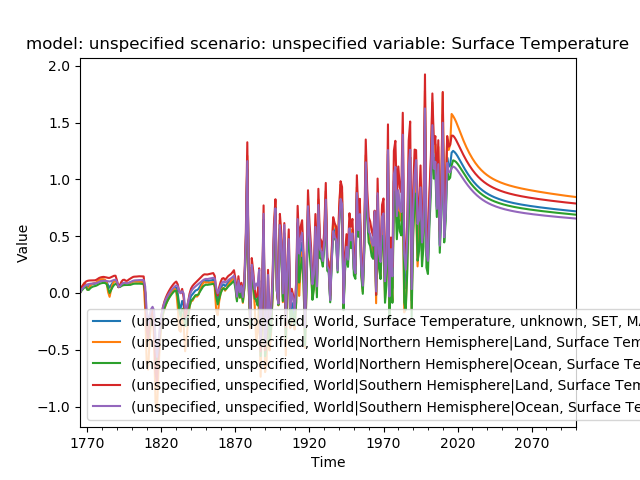

In [3]:
with MAGICC7_SCM() as m:
    print(m.instance().run_dir)
    res = m.run(params.iloc[0].to_dict())
    res.line_plot()


In [4]:
t0 = time()

with MAGICC7_SCM() as m:
    for run_num, r in params.iterrows():
        res = m.run(r.to_dict())

print('time taken: {}s'.format(time() - t0))
print('time taken each run: {}s'.format((time() - t0)/len(params)))

time taken: 44.8476402759552s
time taken each run: 0.44848605394363406s


MAGICC7_SCM also takes in an optional root_dir argument in the constructor. This modifies where the magicc instance is created. Lets set that to the ram disk and see how much faster it is. 

/mnt/ramdisk/pymagicc-m7jv49e5/run


<IPython.core.display.Javascript object>


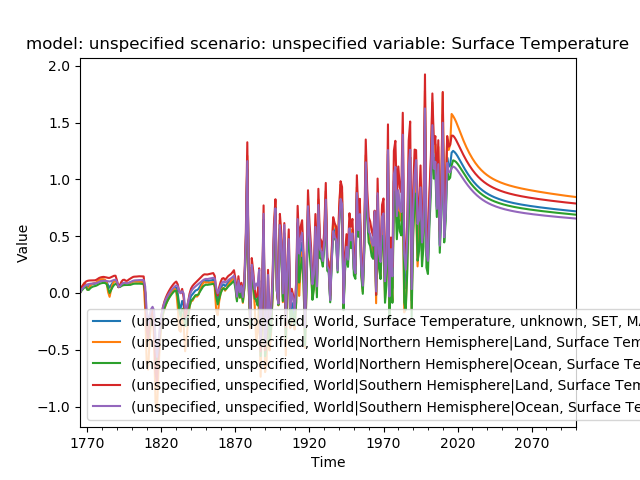

In [5]:
with MAGICC7_SCM(root_dir='/mnt/ramdisk') as m:
    print(m.instance().run_dir)
    res = m.run(params.iloc[0].to_dict())
    res.line_plot()

In [6]:
t0 = time()

with MAGICC7_SCM(root_dir='/mnt/ramdisk') as m:
    for run_num, r in params.iterrows():
        res = m.run(r.to_dict())

print('time taken: {}s'.format(time() - t0))
print('time taken each run: {}s'.format((time() - t0)/len(params)))

time taken: 44.16519856452942s
time taken each run: 0.44165451526641847s


For me it doesn't seem to make too much of an impact